## Making Trees Through ETE3 Toolkit

Notebook code for making tree visualizations where clones are collapsed into sequential leaves and leaves are also colored by Sequencing Type.

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ete3 import Tree, TreeStyle, PhyloTree, TextFace, NodeStyle, SeqMotifFace
from ete3 import faces, AttrFace, CircleFace, TextFace, RectFace

In [40]:
# Reading in newick tree file 
t = Tree("data/2153-reboundOutgrowth.tre") # Tree not PhyloTree!

# Midpoint rooting tree
midpoint = t.get_midpoint_outgroup()
t.set_outgroup(midpoint)

# Ladderize tree
t.ladderize()

31

Pulling sequence type annotation from leaf names. **REMEBER TO CHECK REBOUND PARSER**

In [41]:
# annotating Sequence Type
for leaf in t.iter_leaves():
    if "22" in leaf.name.split("_"):  # Change Rebound Parser!!
        leaf.add_feature("SeqType", 'Rebound') 
    elif 'UDB' in leaf.name.split("_")[1]:
        leaf.add_feature("SeqType", 'Control IgG Outgrowth')
    elif 'AUB' in leaf.name.split("_")[1]:
        leaf.add_feature("SeqType", 'Autologous IgG Outgrowth')
    elif 'STB' in leaf.name.split("_")[1]:
        leaf.add_feature("SeqType", 'No IgG Outgrowth')
    else:
        leaf.add_feature("SeqType", False) # if none, annotate as False

In [42]:
# verify your SeqTypes are being annotated correctly:
for leaf in t.iter_leaves():
    print(leaf.name, leaf.SeqType)

SCOPE2153_STB101trim No IgG Outgrowth
SCOPE2153_STB040trim No IgG Outgrowth
SCOPE2153_STB090trim No IgG Outgrowth
SCOPE2153_UDB062trim Control IgG Outgrowth
2153_22_09_23GTGGTATA Rebound
2153_22_09_23ATCCTAAA Rebound
2153_22_09_23TCTGGTCT Rebound
SCOPE2153_AUB096trim Autologous IgG Outgrowth
SCOPE2153_AUB005trim Autologous IgG Outgrowth
SCOPE2153_AUB024trim Autologous IgG Outgrowth
SCOPE2153_AUB033trim Autologous IgG Outgrowth
SCOPE2153_STB054trim No IgG Outgrowth
SCOPE2153_STB064trim No IgG Outgrowth
SCOPE2153_UDB047trim Control IgG Outgrowth
SCOPE2153_UDB054trim Control IgG Outgrowth
SCOPE2153_STB001trim No IgG Outgrowth
SCOPE2153_AUB009trim Autologous IgG Outgrowth
SCOPE2153_AUB038trim Autologous IgG Outgrowth
SCOPE2153_STB042trim No IgG Outgrowth
SCOPE2153_AUB037trim Autologous IgG Outgrowth
SCOPE2153_AUB055trim Autologous IgG Outgrowth
SCOPE2153_AUB095trim Autologous IgG Outgrowth
SCOPE2153_STB012trim No IgG Outgrowth
SCOPE2153_STB032trim No IgG Outgrowth
SCOPE2153_STB025trim No I

Adding weight annotation to track clones. **Note: clone should be assessed by distance (threshold). If # of base pairs difference used, double check what threshold that equates to**

In [43]:
# Dataframe to track different SeqTypes that are clones
df_cols = ['Rebound', 'Control IgG Outgrowth', 'Autologous IgG Outgrowth', 'No IgG Outgrowth']
leaf_df = pd.DataFrame(index = [leaf.name for leaf in t.iter_leaves()], columns = df_cols)
leaf_df = leaf_df.fillna(0)

/var/folders/6q/p20nqm451ml8pz92lk8nx9br0000gp/T/ipykernel_59937/3497400271.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  leaf_df = leaf_df.fillna(0)


In [44]:
# Add Definition for Weight:
# Weigth if the # of clones, and which nodes should be removed in place
threshold = 1e-06 # set threshold to be ~1 mutation (double check)

def leaf_distance(leaf1, leaf2):
    return t.get_distance(leaf1, leaf2)

# Iterate through each leaf
checked_neighbors = set() # set of every node that has been 'accounted' for

# for every leaf...
for leaf in t.iter_leaves():
    if leaf in checked_neighbors:
        # make sure it wasn't already counted for...
        leaf.add_feature("Weight", -1)
    else:
        weight = 0  # set counter to 0 
        # check every other leaf
        for other_leaf in t.iter_leaves():
            # Exclude the same leaf AND check its not already accounted for
            if other_leaf != leaf and other_leaf not in checked_neighbors:
                distance = leaf_distance(leaf, other_leaf) # get distance
                # if distance passes AND same SeqType
                if distance <= threshold and leaf.SeqType == other_leaf.SeqType: 
                    # add to counter and mark as counted for 
                    weight += 1
                    checked_neighbors.add(other_leaf)
                elif distance <= threshold and leaf.SeqType != other_leaf.SeqType:
                    leaf_df.loc[leaf.name, other_leaf.SeqType] = leaf_df.loc[leaf.name, other_leaf.SeqType] + 1
                    checked_neighbors.add(other_leaf)
        # Assign the weight as a feature to the leaf
        leaf.add_feature("Weight", weight)
        # mark the current leaf as also counted for 
        checked_neighbors.add(leaf)

Plotting tree! Adjust the `t.render()` to either show `%%inline` or to save as a PDF,PNG or SVG file. (**Note: pruning removes clones from tree**)

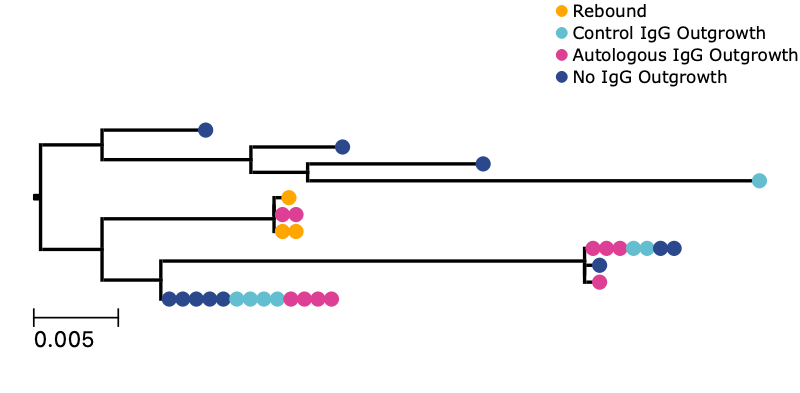

In [46]:
leaves_to_keep = []
for leaf in t.iter_leaves():
    if leaf.Weight != -1:
        leaves_to_keep.append(leaf)
t.prune(leaves_to_keep)

# Colormap for seq type
seqtype_cmap = {
    "Rebound": "#ffa600",
    "Control IgG Outgrowth": "#63bfcf",
    "Autologous IgG Outgrowth": "#DC3F93",
    "No IgG Outgrowth": "#2B488C",
}


# Setting node style
def set_seqtype_color(node):
    if "SeqType" in node.features:
        nstyle = NodeStyle()
        nstyle["fgcolor"] = seqtype_cmap[node.SeqType]
        nstyle["size"] = 8
        nstyle["hz_line_width"] = 2
        node.set_style(nstyle) 
def make_branches_bigger(node, new_size):
    node.img_style["size"] = 0
    node.img_style["hz_line_width"] = new_size # Change the horizotal lines stroke size
    node.img_style["vt_line_width"] = new_size # Change the vertical lines stroke size
for node in t.traverse():
    set_seqtype_color(node)
    for c in node.children:
        make_branches_bigger(c, 2)

# plotting entire tree
ts = TreeStyle()
ts.show_leaf_name = False

def custom_layout(node):
    """
    This function creates the stacking of clonal sequences
    """
    if 'Weight' in node.features:
        if node.Weight != -1:
            for i in range(node.Weight):
                faces.add_face_to_node(faces.CircleFace(4, seqtype_cmap[node.SeqType]), 
                                   node, column=i*2+1, position="branch-right")
            spot_sum = node.Weight
            # Go through the DF of different SeqTypes
            if leaf_df.loc[node.name].sum() > 0:
                for seq_type_i in df_cols:
                    range_val = leaf_df.loc[node.name, seq_type_i]
                    for i in range(range_val):
                        faces.add_face_to_node(faces.CircleFace(4, seqtype_cmap[seq_type_i]), 
                                               node, column=spot_sum*2+1, position="branch-right")
                        spot_sum += 1
ts.layout_fn = custom_layout

ts.margin_left = 20
ts.margin_right = 20
ts.margin_top = 20

# Setting root node
rootstyle = NodeStyle()
rootstyle["size"] = 3
rootstyle["fgcolor"] = 'black'
rootstyle["shape"] = "square"
rootstyle["vt_line_width"] = 2
rootstyle["hz_line_width"] = 2
t.set_style(rootstyle)

# LEGEND INFORMATION
ts.legend.add_face(TextFace(" Rebound", fsize=10), column=1)
ts.legend.add_face(CircleFace(3, "#ffa600"), column=0)

ts.legend.add_face(TextFace(" Control IgG Outgrowth", fsize=10), column=1)
ts.legend.add_face(CircleFace(3, "#63bfcf"), column=0)

ts.legend.add_face(TextFace(" Autologous IgG Outgrowth", fsize=10), column=1)
ts.legend.add_face(CircleFace(3, "#DC3F93"), column=0)

ts.legend.add_face(TextFace(" No IgG Outgrowth", fsize=10), column=1)
ts.legend.add_face(CircleFace(3, "#2B488C"), column=0)
ts.legend_position = 2

# more space between branches
ts.branch_vertical_margin = 2
ts.scale = 10000 # def = 10000

# showing plot
t.render("%%inline", tree_style=ts, w=4, dpi=200, units='in')

In [285]:
t.get_leaves()

[Tree node '2637_23_08_12GACTGCCT' (0x16be4a9d),
 Tree node '2637_23_08_12AGGCGTAG' (0x16be4aa9),
 Tree node '2637_23_08_12ACGCGCAG' (0x16be4a81),
 Tree node '2637_23_08_12CAGGGCGC' (0x16be49c9),
 Tree node '2637_23_08_12GCCCCAGG' (0x16be4a75),
 Tree node '2637_23_08_12GCGTTTCG' (0x16be4af9),
 Tree node '2637_23_08_12GGATGAGT' (0x16be4b29),
 Tree node '2637_23_08_12GTAAGAAG' (0x16be4b09),
 Tree node '2637_23_08_12GTCCTCGG' (0x16be4b3d)]

In [286]:
t.get_distance('2637_23_08_12ACGCGCAG', '2637_23_08_12GGATGAGT')

2e-08

In [251]:
t.get_distance('2637_23_08_12ACGCGCAG', '2637_23_08_12CAGGGCGC')

0.00038949

In [252]:
t.get_distance('2637_23_08_12GCCCCAGG', '2637_23_08_12CAGGGCGC')

0.0007790700000000001